<a href="https://colab.research.google.com/github/NataliaKolesnik/Car_classification/blob/master/Car_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Проект "Классификация автомобилей по изображению"

**Цель:** Классифицировать модель автомобиля по фотографии.

**Задание:** Обучить нейронную сеть определять модель автомомбиля по изображению. Модели автомобилей, представленные в тренировочных данных ('Приора', 'Ford Focus', 'Самара', 'ВАЗ-2110', 'Жигули', 'Нива', 'Калина',   'ВАЗ-2109', 'Volkswagen Passat', 'ВАЗ-21099') 

**Данные:** 
1. train.csv - обучающая выборка
2. train.zip - картинки к обучающей выборке
3. sample-submission.csv - тестовая выборка
4. test.zip - картинки к тестовой выборке




In [ ]:
# проверяем, что видеокарта подключена
!nvidia-smi

Mon May 30 12:47:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Библиотеки:

In [1]:
import os #Для работы с файлами
import sys 
import random
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image #Для отрисовки изображений
%matplotlib inline
from tqdm.notebook import tqdm # ход выполнения

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.activations import *
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M 
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.callbacks import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.layers.experimental.preprocessing import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers.schedules import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
#from gc import callbacks



In [ ]:
# Версии
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

Python       : 3.7.13 (default, Apr 24 2022, 01:04:09) 
Numpy        : 1.21.6
Tensorflow   : 2.8.0
Keras        : 2.8.0


In [ ]:
np.random.seed(42)

## Данные

In [3]:
# Подключаем Google disk
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:

# Распаковываем архивы
!unzip -q '/content/drive/MyDrive/data/sf-dl-car-classification.zip'  -d '/content/cars'
!unzip -q "/content/cars/train.zip" -d '/content/cars/img'
!unzip -q "/content/cars/test.zip" -d '/content/cars/img'


In [5]:
# Загружаем датасеты
train_df = pd.read_csv('/content/cars/train.csv')
test_sub = pd.read_csv('/content/cars/sample-submission.csv')

In [6]:
train_df.sample(3)

,Id,Category
2434,177924.jpg,1
13695,230553.jpg,8
14768,169161.jpg,9


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


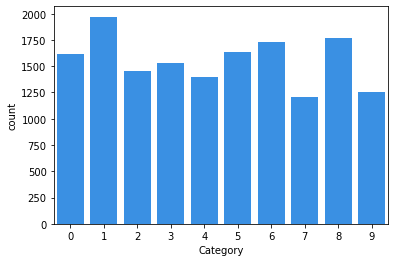

In [8]:
sns.countplot(x='Category', data=train_df, color='dodgerblue')

В обучающей выборке пропусков нет. Объекты распределены по классам не совсем равномерно, но в каждой категории достаточно объектов. 

In [9]:
# Список названий моделей - имена классов
class_names = [
  'Приора', #0
  'Ford Focus', #1
  'Самара', #2
  'ВАЗ-2110', #3
  'Жигули', #4
  'Нива', #5
  'Калина', #6
  'ВАЗ-2109', #7
  'Volkswagen Passat', #8
  'ВАЗ-21099' #9
]

**Посмотрим изображения автомобилей**

In [10]:
# Пути до изображений
train_img_path = '/content/cars/img/train/'
test_img_path = '/content/cars/img/test_upload/'

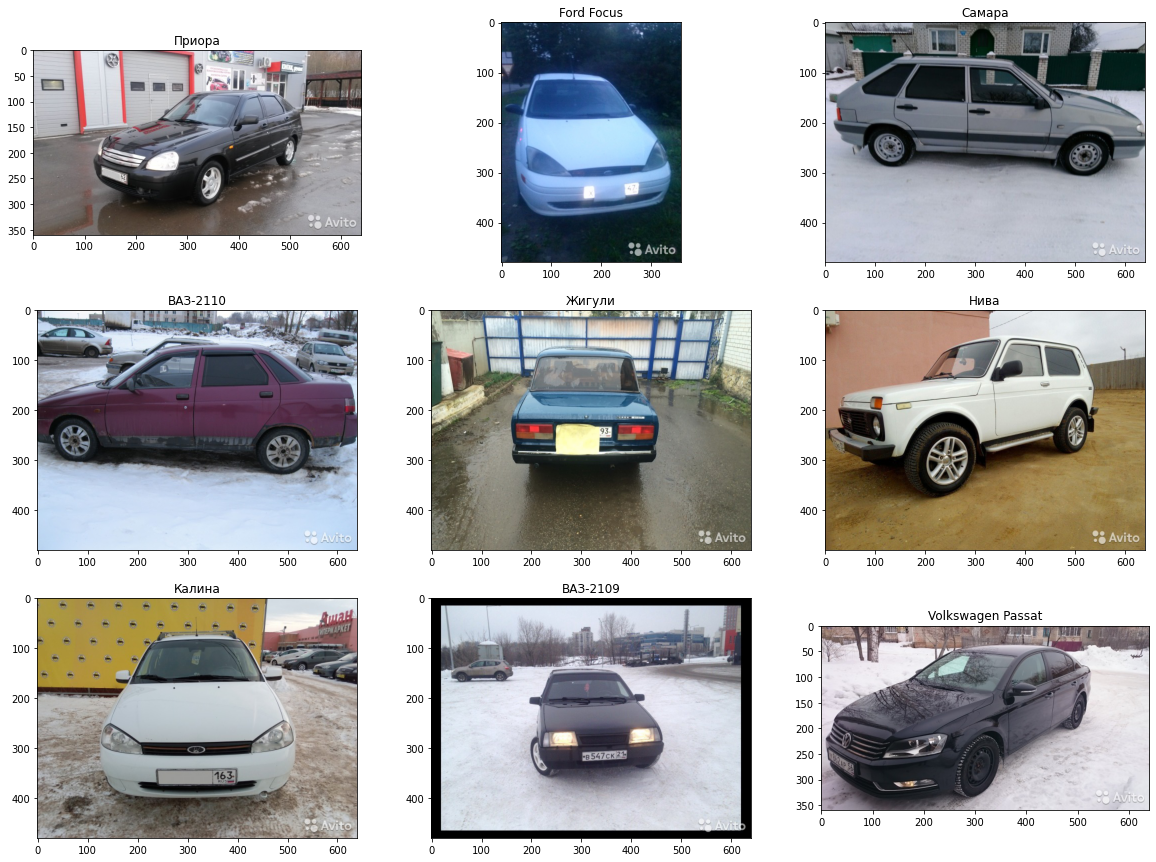

In [11]:
from IPython.core.pylabtools import figsize
fig, ax = plt.subplots(3, 3, figsize=(20,15))
for i, axi in enumerate(ax.flat):
    car_path = train_img_path + str(i)+'/'
    img_path = car_path + random.choice(os.listdir(car_path))
    img = Image.open(img_path)
    axi.imshow(img)
    axi.set_title(class_names[i])
plt.show()

Фотографии в разном разрешении, в основном размером 640 на 480. Автомобили сняты с разного ракурса.

## Подготовка данных для нейросети

**Основные насройки**

In [12]:
LR=0.001
IMAGE_SIZE = (160, 200)
BATCH_SIZE = 50
RANDOM_SEED = 42
EPOCHS = 30
VALIDATION_SPLIT=0.25 # процент данных на валидацию
OPTIMIZER=optimizers.Adam(learning_rate=LR)


**Аугментация данных**

In [13]:
train_datagen = ImageDataGenerator(
    #rescale = 1./255, # Нормализуем яркости от 0 до 1
    rotation_range=10, # Поворачиваем изображения при генерации выборки
    horizontal_flip=True, # Отзеркаливание изображения
    shear_range=0.2, # Задает диапазон сдвига пикселей изображения (угол сдвига в градусах в направлении против часовой стрелки)
    zoom_range=[0.85, 1.15], # Зумируем катринку 
    width_shift_range=0.1, # Двигаем по ширине 
    height_shift_range=0.1, # Двигаем по высоте
    brightness_range=(0.8, 1.2), # Диапазон для выбора значения сдвига яркости.
    validation_split=VALIDATION_SPLIT # Указываем разделение изображений на обучающую и тестовую выборку
)

valid_datagen = ImageDataGenerator(
    #rescale = 1./255, # нормализуем яркости от 0 до 1
    validation_split=VALIDATION_SPLIT # Указываем разделение изображений на обучающую и тестовую выборку
)

test_datagen = ImageDataGenerator(
    #rescale = 1./255 # нормализуем яркости от 0 до 1
)

**Генерация данных**

In [14]:
train_generator = train_datagen.flow_from_directory(
    train_img_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    subset='training'
    
)

valid_generator = valid_datagen.flow_from_directory(
    train_img_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    subset='validation'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_sub,
    directory=test_img_path,
    x_col='Id',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False

)

Found 11675 images belonging to 10 classes.
Found 3886 images belonging to 10 classes.
Found 6675 validated image filenames.


Посмотрим, что получилось:

In [15]:
def show_first_image(generator, count=6, labels=True, figsize=(20, 5), normalized=False):
    """Функция выводит на экран изображения, обработанные генератором"""

    generator = itertools.islice(generator, count) # Создаёт итератор по ограниченному подмножеству элементов переданного объекта.
    fig, ax = plt.subplots(nrows=1, ncols=count, figsize=figsize)
  
    for batch, ax in zip(generator, ax):
    
      if labels:
          img_batch, labels_batch = batch
          img, label = img_batch[0], np.argmax(labels_batch[0])
      else:
          img_batch = batch
          img = img_batch[0]
    
      if not normalized:
          img = img.astype(np.uint8)
    
      ax.imshow(img)
    # метод imshow принимает одно из двух:
    # - изображение в формате uint8, яркость от 0 до 255
    # - изображение в формате float, яркость от 0 до 1

      if labels:
          ax.set_title(f'Class: {label}')
  
    plt.show()




Обучающая выборка:


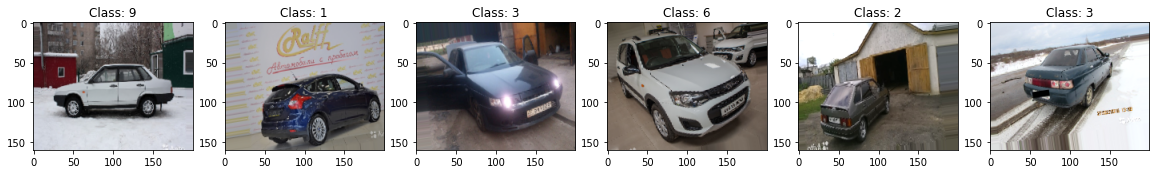

Валидационная выборка:


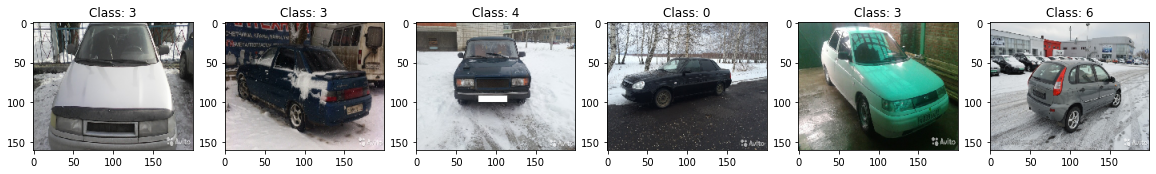

Тестовая выборка:


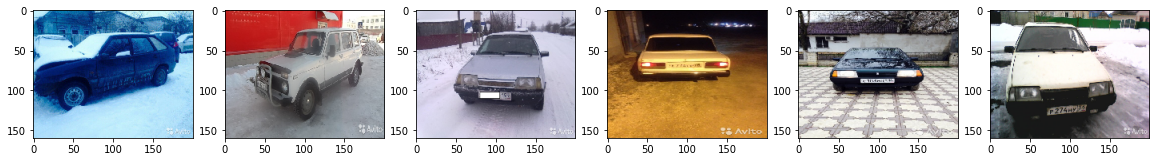

In [16]:
print('Обучающая выборка:')
show_first_image(train_generator)

print('Валидационная выборка:')
show_first_image(valid_generator)

print('Тестовая выборка:')
show_first_image(test_generator, labels=False)


## Построение модели и обучение

In [ ]:
# путь для сохранения модели
path_model = '/content/drive/MyDrive/data/models/EfficientNetV2M/'

In [ ]:
# EfficientNetV2M - памяти не хватает

# Загружаем предобученную сеть EfficientNetV2M:

base_model = EfficientNetV2M(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))

214212608/214201816 [==============================] - 1s 0us/step


In [ ]:
# Если надо посмотреть - раскомментировать
# base_model.summary()

In [ ]:
# Сохранение лучшей модели
checkpoint = ModelCheckpoint(path_model+'best_model.hdf5', monitor=['val_accuracy'], verbose=1, mode='max')
# Останавливаемся если наша модель уже не обучается
earlystop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, )
# Сохраняем резервную копию
#backup = BackupAndRestore(backup_dir="/content/drive/MyDrive/data/models/EfficientNetV2M")

callbacks_list = [checkpoint, earlystop] #, backup]

### 1 Шаг

**Модель**

In [ ]:
# Заморозим веса, чтоб базовая модель не обучалась
base_model.trainable = False

In [ ]:
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D(),) # Объединяет признаки в единый вектор
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

In [ ]:
model.summary()

In [ ]:
# Проверяем сколько и каких слоев обучаем:
print(f'Обучаем: {len(model.trainable_variables)} слоя(ев)')

for layer in model.layers:
    print(layer, layer.trainable)

In [ ]:
LR = 0.001 # learning_rate
model.compile(
    loss='categorical_crossentropy',
    optimizer=OPTIMIZER,
    metrics=['accuracy']
)

**Обучение**

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples//valid_generator.batch_size,
    epochs=EPOCHS,
    callbacks=callbacks_list
)

In [ ]:
# Сохраняем модель
model.load_weights(path_model+'best_model.hdf5')
model.save(path_model+'model_step_1')
model.save(path_model+'model_step_1.hdf5')

In [ ]:
scores = model.evaluate_generator(valid_generator, steps=len(valid_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))  

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))
 
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
 
    plt.figure()
 
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [ ]:
plot_history(history)

### 2 Шаг

Так как colab не дает полностью пройти модель, то восстановим последюю сохраненную версию и веса из best_model

In [ ]:
# model = load_model(path_model+'model_step_1')


**Модель**

In [ ]:
# Разаморозим половину весов
model.layers[0].trainable = True

# Заморозим первую половину слоев базовой модели
first_layers_disable = len(model.layers[0].layers)//2
print(f'Заморожено первых {first_layers_disable} слоя(ев)')

for layer in model.layers[0].layers[:first_layers_disable]:
    layer.trainable = False

In [ ]:
# Проверяем сколько и каких слоев обучаем:
print(f'Обучаем: {len(model.trainable_variables)} слоя(ев)')

for layer in model.layers:
    print(layer, layer.trainable)

In [ ]:
LR = 0.001 # learning_rate
model.compile(
    loss='categorical_crossentropy',
    optimizer=OPTIMIZER,
    metrics=['accuracy']
)

In [ ]:
model.summary()

**Обучение**

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples//valid_generator.batch_size,
    epochs=EPOCHS,
    callbacks=callbacks_list
)

In [ ]:
# Сохраняем модель
model.load_weights(path_model+'best_model.hdf5')
model.save(path_model+'model_step_2')
model.save(path_model+'model_step_2.hdf5')

In [ ]:
scores = model.evaluate_generator(valid_generator, steps=1, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
plot_history(history) 

### 3 Шаг

Так как colab не дает полностью пройти модель, то восстановим последюю сохраненную версию и веса из best_model

In [ ]:
# model = load_model(path_model+'model_step_2')

**Модель**

In [ ]:
# Разаморозим 3/4 части весов
model.layers[0].trainable = True

# Заморозим первую половину слоев базовой модели
first_layers_disable = len(model.layers[0].layers)//4
print(f'Заморожено первых {first_layers_disable} слоя(ев)')    

for layer in model.layers[0].layers[:first_layers_disable]:
    layer.trainable = False

In [ ]:
# Проверяем сколько и каких слоев обучаем:
print(f'Обучаем: {len(model.trainable_variables)} слоя(ев)')

for layer in model.layers:
    print(layer, layer.trainable)

In [ ]:
LR = 0.0005 # learning_rate
model.compile(
    loss='categorical_crossentropy',
    optimizer=OPTIMIZER,
    metrics=['accuracy']
)

In [ ]:
model.summary()

**Обучаем**

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples//valid_generator.batch_size,
    epochs=EPOCHS,
    callbacks=callbacks_list
)

In [ ]:
# Сохраняем модель
model.load_weights(path_model+'best_model.hdf5')
model.save(path_model+'model_step_3')
model.save(path_model+'model_step_3.hdf5')

In [ ]:
scores = model.evaluate_generator(valid_generator, steps=1, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
plot_history(history)

### 4 Шаг

**Модель**

In [ ]:
model = load_model(path_model+'model_step_3')

In [ ]:
# Разморозим все веса
model.layers[0].trainable = True

# Проверяем сколько и каких слоев обучаем:
print(f'Обучаем: {len(model.trainable_variables)} слоя(ев)')

for layer in model.layers:
    print(layer, layer.trainable)

Обучаем: 653 слоя(ев)
<keras.engine.functional.Functional object at 0x7eff9cc136d0> True
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7eff99e653d0> True
<keras.layers.core.dense.Dense object at 0x7eff99b1e590> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7eff99ae66d0> True
<keras.layers.core.dropout.Dropout object at 0x7eff99aa6810> True
<keras.layers.core.dense.Dense object at 0x7eff99aab210> True


In [ ]:
LR = 0.0001 # learning_rate
EPOCHS=30
model.compile(
    loss='categorical_crossentropy',
    optimizer=OPTIMIZER,
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-m (Functiona  (None, 5, 7, 1280)       53150388  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

**Обучаем**

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples//valid_generator.batch_size,
    epochs=EPOCHS,
    callbacks=callbacks_list
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/30
233/233 [==============================] - ETA: 0s - loss: 0.1011 - accuracy: 0.9662
Epoch 1: saving model to /content/drive/MyDrive/data/models/EfficientNetV2M/best_model.hdf5
233/233 [==============================] - 292s 1s/step - loss: 0.1011 - accuracy: 0.9662 - val_loss: 0.1960 - val_accuracy: 0.9426
Epoch 2/30
233/233 [==============================] - ETA: 0s - loss: 0.0917 - accuracy: 0.9695
Epoch 2: saving model to /content/drive/MyDrive/data/models/EfficientNetV2M/best_model.hdf5
233/233 [==============================] - 250s 1s/step - loss: 0.0917 - accuracy: 0.9695 - val_loss: 0.2132 - val_accuracy: 0.9364
Epoch 3/30
233/233 [==============================] - ETA: 0s - loss: 0.0792 - accuracy: 0.9742
Epoch 3: saving model to /content/drive/MyDrive/data/models/EfficientNetV2M/best_model.hdf5
233/233 [==============================] - 246s 1s/step - loss: 0.0792 - accuracy: 0.9742 - val_loss: 0.1938 - val_accuracy: 0.9442
Epoch 4/30
233/233 [====================

KeyboardInterrupt: ignored

In [ ]:
# Сохраняем модель
model.load_weights(path_model+'best_model.hdf5')
model.save(path_model+'model_step_4')
model.save(path_model+'model_step_4.hdf5')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/data/models/EfficientNetV2M/model_step_4/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/data/models/EfficientNetV2M/model_step_4/assets


In [ ]:
scores = model.evaluate_generator(valid_generator, steps=1, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


1/1 [==============================] - 1s 713ms/step - loss: 0.1771 - accuracy: 0.9400
Accuracy: 94.00%


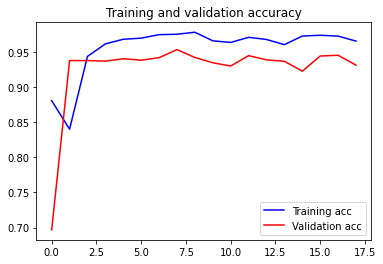

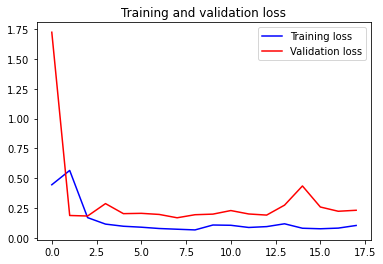

In [ ]:
plot_history(history)

## Предсказываем на тестовых данных

In [ ]:
test_generator.reset()
predictions = model.predict_generator(test_generator, steps=len(test_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


134/134 [==============================] - 50s 341ms/step


In [ ]:
filenames_with_dir=test_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv(path_model+'submission.csv', index=False)
print('Save submit')

Save submit


In [ ]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,9
